In [ ]:
import os
from os import listdir
from PIL import Image as Img
from numpy import asarray
from numpy import expand_dims
from matplotlib import pyplot
from keras.models import load_model
import numpy as np
import tensorflow as tf

import pickle
import cv2

In [ ]:
! pip install keras-facenet

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 19.5 MB/s eta 0:00:00
  Created wheel for keras-facenet: filename=keras_facenet-0.3.2-py3-none-any.whl size=10370 sha256=7f40ec3748a5f4b4aeb425aee76bb89294c1c083f601adb732be60fb6a674457
  Stored in directory: /root/.cache/pip/wheels/1d/d8/a9/85cf04ea29321d2afcb82c0caaafdca9195385f9d68cbc7185
Successfully built keras-facenet


In [ ]:
from keras_facenet import FaceNet


In [ ]:
HaarCascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))
MyFaceNet = FaceNet()


In [ ]:
folder='/content/foto'
database = {}

for filename in listdir(folder):

    path = folder + "/" + filename
    gbr1 = cv2.imread(path)

    wajah = HaarCascade.detectMultiScale(gbr1,1.1,4)

    if len(wajah)>0:
        x1, y1, width, height = wajah[0]
    else:
        x1, y1, width, height = 1, 1, 10, 10

    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height

    gbr = cv2.cvtColor(gbr1, cv2.COLOR_BGR2RGB)
    gbr = Img.fromarray(gbr)                  # konversi dari OpenCV ke PIL
    gbr_array = asarray(gbr)

    face = gbr_array[y1:y2, x1:x2]

    face = Img.fromarray(face)
    face = face.resize((160,160))
    face = asarray(face)



    face = expand_dims(face, axis=0)
    signature = MyFaceNet.embeddings(face)

    database[os.path.splitext(filename)[0]]=signature

1/1 [==============================] - 0s 152ms/step


error: ignored

In [ ]:
database

{'unknown': array([[-1.75243225e-02, -1.85861569e-02, -4.27886881e-02,
          2.54346300e-02, -1.21030584e-02,  3.97468880e-02,
         -8.70033801e-02,  1.92085989e-02, -9.92007740e-03,
          6.28365129e-02,  6.86099827e-02,  6.55633733e-02,
         -1.86462700e-02, -5.79801761e-02,  1.47832548e-02,
         -3.67276147e-02,  7.85625074e-03,  4.88509126e-02,
          1.36452252e-02, -2.52033081e-02, -6.00556731e-02,
          4.91075926e-02,  8.87676030e-02, -8.55068564e-02,
         -4.49774489e-02,  9.85793024e-03,  1.96010303e-02,
         -2.77827214e-03, -5.28946258e-02, -1.11580291e-03,
         -1.39899794e-02,  6.86470643e-02,  2.58411653e-02,
          2.07707323e-02, -3.77106480e-03, -7.48843281e-03,
          9.04562883e-03, -1.66477263e-02, -4.34357636e-02,
          3.66611630e-02,  1.51558043e-02, -4.26938161e-02,
         -2.68841791e-03,  1.98495761e-02,  1.73952468e-02,
         -2.05850415e-02,  3.48734632e-02,  1.77683607e-02,
         -9.62350443e-02, -1.

In [ ]:

myfile = open("data.pkl", "wb")
pickle.dump(database, myfile)
myfile.close()

In [ ]:

myfile = open("data.pkl", "rb")
database = pickle.load(myfile)
myfile.close()


In [ ]:
def js_to_image(js_reply):
  image_bytes = b64decode(js_reply.split(',')[1])
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  img = cv2.imdecode(jpg_as_np, flags=1)
  return img

In [ ]:
def findFaces(data,target):
  gbr1 = js_to_image(data)
  gbr = cv2.cvtColor(gbr1, cv2.COLOR_BGR2RGB)
  gbr = Img.fromarray(gbr)                  # konversi dari OpenCV ke PIL
  gbr_array = asarray(gbr)

  wajah = HaarCascade.detectMultiScale(gbr1,1.1,4)

  for (x1,y1,w,h) in wajah:
      x1, y1 = abs(x1), abs(y1)
      x2, y2 = x1 + w, y1 + h

      face = gbr_array[y1:y2, x1:x2]

      face = Img.fromarray(face)
      face = face.resize((160,160))
      face = asarray(face)

      face = expand_dims(face, axis=0)
      signature = MyFaceNet.embeddings(face)

      min_dist=100
      identity=' '
      for key, value in database.items() :
        dist = np.linalg.norm(value-signature)
        if dist < min_dist:
          min_dist = dist
          identity = key

      #모자이크 구현
      if identity != target:
        mosaic_face = cv2.resize(gbr1[y1:y2, x1:x2], (w // 10, h // 10))
        mosaic_face = cv2.resize(mosaic_face, (w, h), interpolation=cv2.INTER_NEAREST)
        gbr1[y1:y2, x1:x2] = mosaic_face

      cv2.putText(gbr1,identity, (x1,y1),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 1, cv2.LINE_AA)
      cv2.rectangle(gbr1,(x1,y1),(x2,y2), (0,255,0), 2)

  filename='photo.jpg'
  cv2.imwrite(filename, gbr1)

  return filename

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))

  filename=findFaces(data,"chansoo")

  return filename

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 173ms/step
Saved to photo.jpg


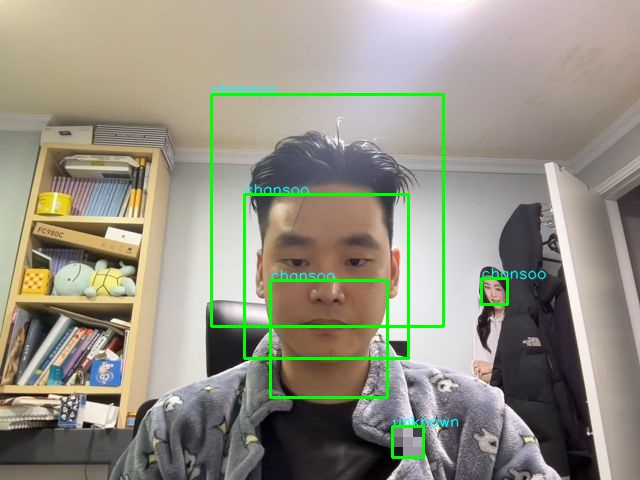

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))


In [ ]:
from PIL import Image

from keras.models import load_model
import numpy as np
from numpy import asarray
from numpy import expand_dims

import pickle
import cv2

In [ ]:
HaarCascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))
MyFaceNet = FaceNet()

In [ ]:
myfile = open("data.pkl", "rb")
database = pickle.load(myfile)
myfile.close()

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 98ms/step
Saved to photo.jpg


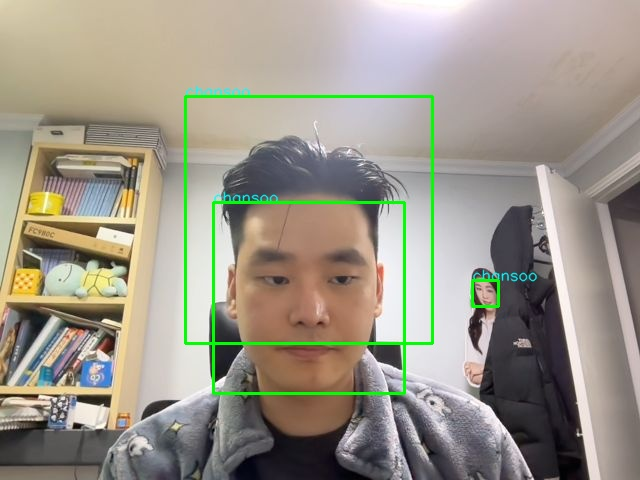

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))


In [ ]:
!pip install pillow

In [ ]:
database

{}

In [ ]:
folder='fotoPeserta/'
database = {}

for filename in listdir(folder):

    path = folder + filename
    gbr1 = cv2.imread(folder + filename)

    wajah = HaarCascade.detectMultiScale(gbr1,1.1,4)

    if len(wajah)>0:
        x1, y1, width, height = wajah[0]
    else:
        x1, y1, width, height = 1, 1, 10, 10

    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height

    gbr = cv2.cvtColor(gbr1, cv2.COLOR_BGR2RGB)
    gbr = Image.fromarray(gbr)                  # konversi dari OpenCV ke PIL
    gbr_array = asarray(gbr)

    face = gbr_array[y1:y2, x1:x2]

    face = Image.fromarray(face)
    face = face.resize((160,160))
    face = asarray(face)

    face = expand_dims(face, axis=0)
    signature = MyFaceNet.embeddings(face)

    database[os.path.splitext(filename)[0]]=signature

AttributeError: ignored